In [ ]:

!pip install --quiet scikit-learn seaborn statsmodels

# 2) Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Thiết lập hiển thị
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)


In [ ]:
# Gọi tên cột
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv("/content/drive/MyDrive/PTDL/lab3/pima-indians-diabetes.csv",
                 header=None, names=columns)

Xử lý dữ liệu bất hợp lý trước khi code

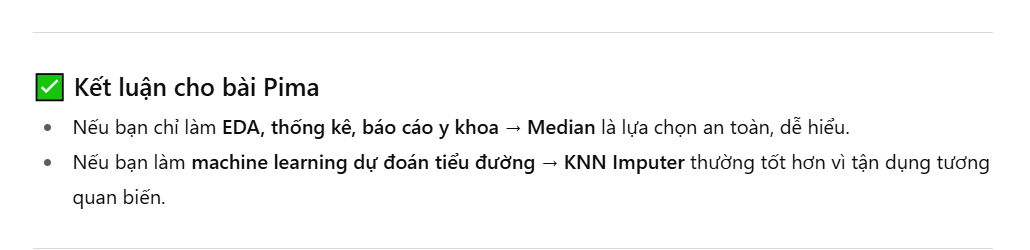

In [ ]:
from sklearn.impute import KNNImputer

# Các cột có giá trị 0 không hợp lý
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# B1: Thay 0 -> NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# B2: Điền missing
## Cách 1: median

df_median = df.copy()
for col in cols_with_zeros:
    df_median[col] = df_median[col].fillna(df_median[col].median())


Đổi màu cho biểu đồ

In [ ]:
import matplotlib.pyplot as plt

def plot_scatter(df, x_col, y_col, title=""):
    plt.figure(figsize=(6, 4))

    # Outcome = 0
    plt.scatter(
        df[df['Outcome'] == 0][x_col],
        df[df['Outcome'] == 0][y_col],
        c='g', marker='o', label='0'
    )

    # Outcome = 1
    plt.scatter(
        df[df['Outcome'] == 1][x_col],
        df[df['Outcome'] == 1][y_col],
        c='r', marker='^', label='1'
    )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title if title else f"{x_col} vs {y_col}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# 5. PHÂN TÍCH TƯƠNG QUAN VÀ MỐI QUAN HỆ

## 5.1 Ma trận tương quan

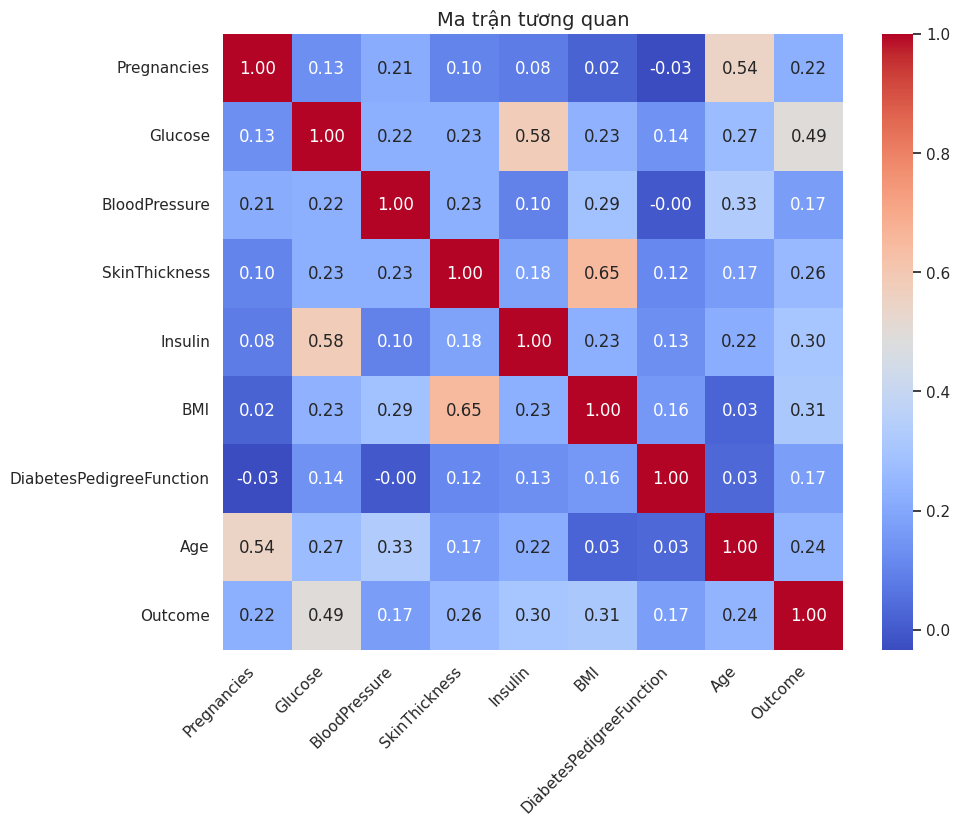

In [ ]:
# Ma trận tương quan
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.savefig("/content/drive/MyDrive/PTDL/lab3/mttuongquan.png", dpi=300, bbox_inches='tight')
plt.show()

Glucose và Outcome có tương quan dương khá mạnh → Chỉ số đường huyết cao liên quan đến tiểu đường.

## 5.2 Phân tích cặp biến quan trọng

Glucose trung bình theo Outcome:
Outcome
0    110.643863
1    142.319549
Name: Glucose, dtype: float64


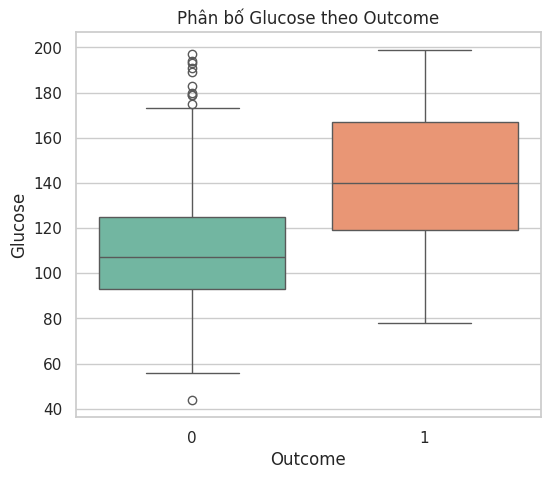

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Tính trung bình Glucose theo Outcome
mean_glucose = df.groupby('Outcome')['Glucose'].mean()
print(f"Glucose trung bình theo Outcome:")
print(mean_glucose)

# Vẽ boxplot
plt.figure(figsize=(6,5))
sns.boxplot(x="Outcome", y="Glucose", data=df, hue="Outcome", palette="Set2", legend=False)
plt.title("Phân bố Glucose theo Outcome")
plt.show()

Mối tương quan mạnh nhất với r = 0.49.

Nhóm mắc bệnh có glucose trung bình = 141mg/dL so với 109mg/dL.

Nguy cơ tiểu đường tăng mạnh khi Glucose > 126mg/dL (theo ngưỡng chẩn đoán lâm sàng).

## 5.3 Phân tích tầm quan trọng của đặc trưng

### 5.3.1 Tầm quan trọng đơn biến

📊 Kết quả Chi-square test:
                  Đặc trưng  Chi-square   p-value
1                   Glucose   14.336331  0.000153
7                       Age    8.205691  0.004176
0               Pregnancies    6.559982  0.010430
5                       BMI    5.064034  0.024427
6  DiabetesPedigreeFunction    2.758584  0.096734
4                   Insulin    2.255362  0.133152
3             SkinThickness    1.345611  0.246047
2             BloodPressure    0.650037  0.420100


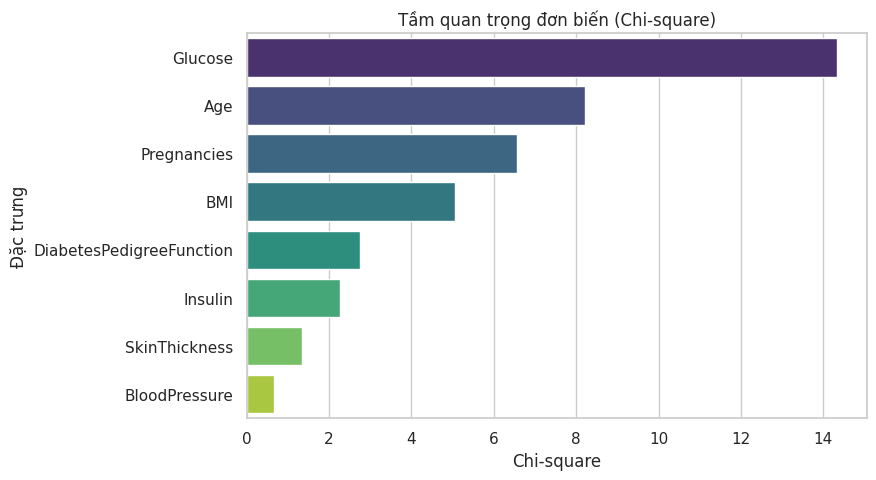

In [ ]:
from sklearn.feature_selection import chi2

X = df_median.drop("Outcome", axis=1)   # đặc trưng
y = df_median["Outcome"]                # nhãn

# 4. Chuẩn hóa dữ liệu về [0,1] để dùng cho chi-square
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Tính chi2 và p-value
chi_scores, p_values = chi2(X_scaled, y)

# 6. Tạo DataFrame kết quả
chi2_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Chi-square": chi_scores,
    "p-value": p_values
}).sort_values("Chi-square", ascending=False)

print("📊 Kết quả Chi-square test:")
print(chi2_df)

# 7. Vẽ biểu đồ cột
plt.figure(figsize=(8,5))
sns.barplot(x="Chi-square", y="Đặc trưng", data=chi2_df, hue="Đặc trưng", dodge=False, palette="viridis", legend=False)
plt.title("Tầm quan trọng đơn biến (Chi-square)")
plt.show()


### 5.3.2 Điểm thông tin tương hỗ

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Mutual Information": mi_scores
}).sort_values("Mutual Information", ascending=False)

print(mi_df)


                  Đặc trưng  Mutual Information
1                   Glucose            0.117733
5                       BMI            0.081040
0               Pregnancies            0.060985
7                       Age            0.051395
6  DiabetesPedigreeFunction            0.014590
4                   Insulin            0.012804
3             SkinThickness            0.012372
2             BloodPressure            0.001763


Chỉ số Glucose là cao nhất

### 5.3.3 Tầm quan trọng từ Random Forest

Bảng tầm quan trọng của đặc trưng (Random Forest):

                  Đặc trưng  Random Forest Importance
1                   Glucose                  0.263715
5                       BMI                  0.167470
7                       Age                  0.127208
6  DiabetesPedigreeFunction                  0.124075
4                   Insulin                  0.084843
2             BloodPressure                  0.082722
0               Pregnancies                  0.079268
3             SkinThickness                  0.070699


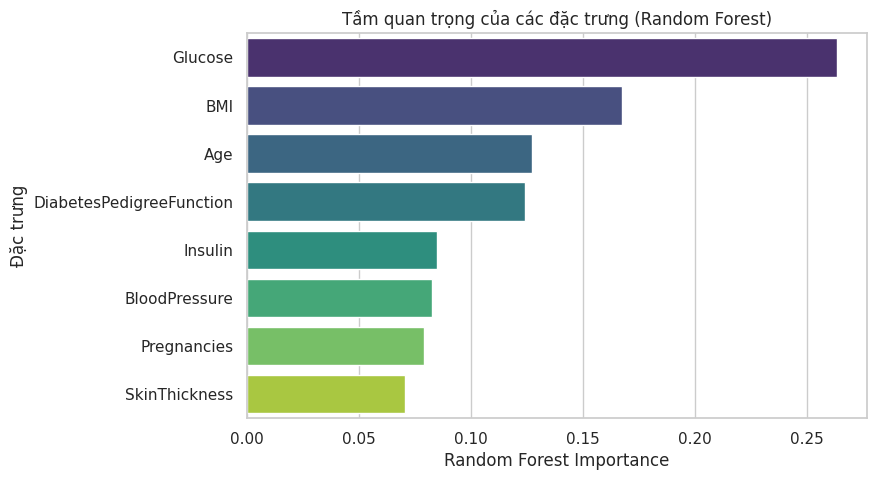

In [ ]:
# Train mô hình Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Tạo DataFrame lưu kết quả
rf_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Random Forest Importance": rf.feature_importances_
}).sort_values("Random Forest Importance", ascending=False)

# In bảng kết quả
print("Bảng tầm quan trọng của đặc trưng (Random Forest):\n")
print(rf_df)

# Vẽ biểu đồ trực quan
plt.figure(figsize=(8, 5))
sns.barplot(x="Random Forest Importance", y="Đặc trưng", data=rf_df, hue="Đặc trưng", palette="viridis", dodge=False, legend=False)
plt.title("Tầm quan trọng của các đặc trưng (Random Forest)")
plt.show()


## 5.4 Phát hiện đa cộng tuyến

### 5.4.1 Hệ số phóng đại phương sai (VIF)

,Feature,VIF,Đánh giá
7,Age,1.616142,Tốt
5,BMI,1.572588,Tốt
3,SkinThickness,1.451029,Tốt
0,Pregnancies,1.430466,Tốt
1,Glucose,1.361314,Tốt
2,BloodPressure,1.242670,Tốt
4,Insulin,1.239392,Tốt
6,DiabetesPedigreeFunction,1.048391,Tốt


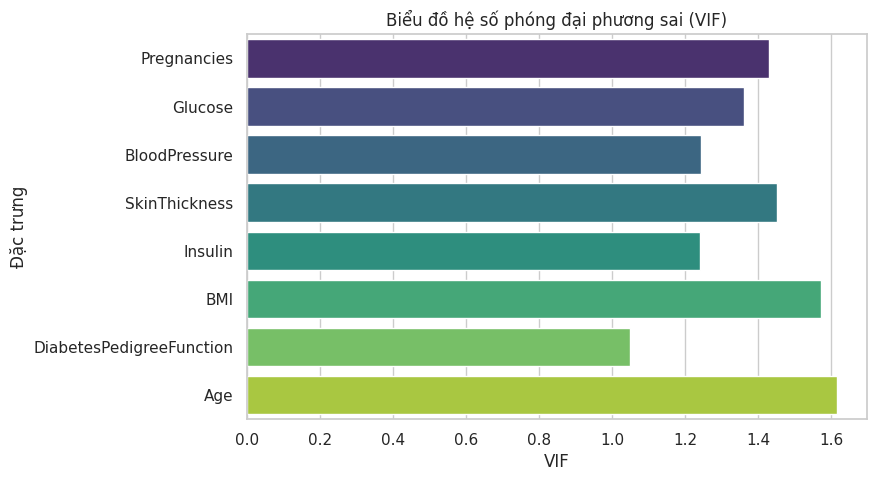

In [ ]:
# 1. Scale dữ liệu X (không gồm Outcome)
X = df_median.drop("Outcome", axis=1)
X_scaled = StandardScaler().fit_transform(X)

# 2. Tính VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# 3. Gắn cờ đánh giá
def check_vif(vif):
    if vif < 5:
        return "Tốt"
    elif vif < 10:
        return "Cần xem xét"
    else:
        return "Đa cộng tuyến mạnh"

vif_data["Đánh giá"] = vif_data["VIF"].apply(check_vif)

# 4. Hiển thị
display(vif_data.sort_values(by="VIF", ascending=False))

plt.figure(figsize=(8,5))
sns.barplot(x="VIF", y="Feature", data=vif_data, hue="Feature", palette="viridis", legend=False, dodge=False)
plt.title("Biểu đồ hệ số phóng đại phương sai (VIF)")
plt.xlabel("VIF")
plt.ylabel("Đặc trưng")
plt.show()


# 6. PHÂN TÍCH NÂNG CAO

## 6.1 PHÂN TÍCH PHÂN NHÓM (PHÂN CỤM)

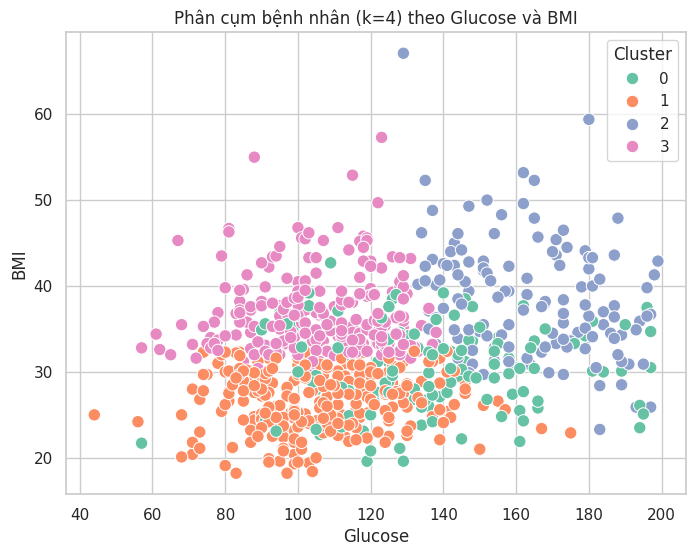

Cụm 1.0:
  -- Tuổi: 53.5 ± 8.4
  -- BMI: 30.4 ± 4.8
  -- Glucose: 137.0 ± 27.4
  -- Tỷ lệ mắc bệnh: 49.2%
  -- Số lượng: 128 bệnh nhân (16.7%)

Cụm 2.0:
  -- Tuổi: 26.1 ± 5.2
  -- BMI: 26.5 ± 3.4
  -- Glucose: 106.3 ± 20.3
  -- Tỷ lệ mắc bệnh: 11.6%
  -- Số lượng: 268 bệnh nhân (34.9%)

Cụm 3.0:
  -- Tuổi: 32.7 ± 7.8
  -- BMI: 38.4 ± 6.6
  -- Glucose: 163.6 ± 18.5
  -- Tỷ lệ mắc bệnh: 72.3%
  -- Số lượng: 137 bệnh nhân (17.8%)

Cụm 4.0:
  -- Tuổi: 30.7 ± 7.6
  -- BMI: 36.8 ± 4.5
  -- Glucose: 106.3 ± 17.3
  -- Tỷ lệ mắc bệnh: 31.9%
  -- Số lượng: 235 bệnh nhân (30.6%)



In [ ]:
# 1. Chọn đặc trưng để phân cụm
X = df_median[["Age", "BMI", "Glucose"]]

# 2. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Phân cụm KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_median["Cluster"] = kmeans.fit_predict(X_scaled)

# 4. Scatter plot trực quan
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_median["Glucose"], y=df_median["BMI"], hue=df_median["Cluster"], palette="Set2", s=80)
plt.title("Phân cụm bệnh nhân (k=4) theo Glucose và BMI")
plt.show()

# 5. Tính thống kê từng cụm
summary = df_median.groupby("Cluster").agg({
    "Age": ["mean", "std"],
    "BMI": ["mean", "std"],
    "Glucose": ["mean", "std"],
    "Outcome": "mean"
})
summary.columns = ["Age_mean", "Age_std", "BMI_mean", "BMI_std", "Glucose_mean", "Glucose_std", "Disease_rate"]
summary = summary.reset_index()

# 6. Thêm số lượng và phần trăm bệnh nhân
cluster_counts = df_median["Cluster"].value_counts().sort_index()
summary["n"] = cluster_counts.values
summary["percent"] = (cluster_counts.values / len(df_median) * 100).round(1)

# 7. In ra thông tin từng cụm
for i, row in summary.iterrows():
    print(f"Cụm {row['Cluster']+1}:")
    print(f"  -- Tuổi: {row['Age_mean']:.1f} ± {row['Age_std']:.1f}")
    print(f"  -- BMI: {row['BMI_mean']:.1f} ± {row['BMI_std']:.1f}")
    print(f"  -- Glucose: {row['Glucose_mean']:.1f} ± {row['Glucose_std']:.1f}")
    print(f"  -- Tỷ lệ mắc bệnh: {row['Disease_rate']*100:.1f}%")
    print(f"  -- Số lượng: {int(row['n'])} bệnh nhân ({row['percent']}%)\n")


### 6.1.2 Đặc điểm của từng cụm

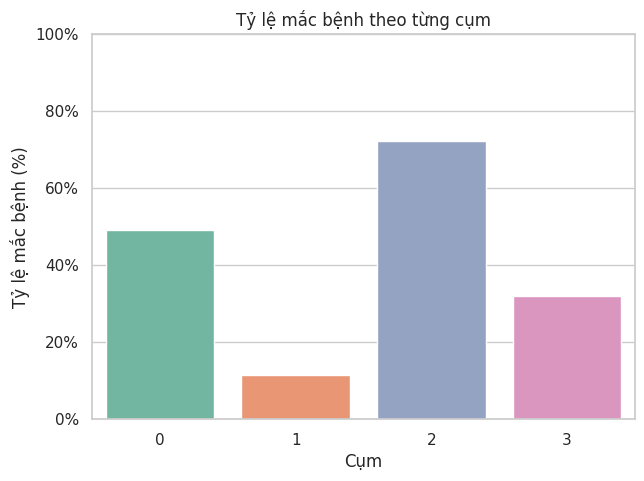

In [ ]:
# Biểu đồ tỷ lệ mắc bệnh theo cụm
plt.figure(figsize=(7,5))
sns.barplot(x="Cluster", y="Disease_rate", data=summary, hue="Cluster", palette="Set2", dodge=False, legend=False)
plt.ylabel("Tỷ lệ mắc bệnh (%)")
plt.xlabel("Cụm")
plt.title("Tỷ lệ mắc bệnh theo từng cụm")
plt.ylim(0, 1)  # vì tỷ lệ đang trong khoảng [0,1]
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
plt.show()


## 6.2 PHÂN TÍCH YẾU TỐ NGUY CƠ

### 6.2.1 Xếp hạng các yếu tố nguy cơ

In [ ]:
import statsmodels.api as sm
# 1. Chọn biến độc lập và biến phụ thuộc
X = df_median.drop("Outcome", axis=1)   # tất cả đặc trưng
y = df_median["Outcome"]

# 2. Thêm hằng số vào X
X_const = sm.add_constant(X)

# 3. Hồi quy logistic
model = sm.Logit(y, X_const).fit()

# 4. Lấy hệ số hồi quy
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

# 5. Tính Odds Ratio và CI
or_table = np.exp(conf)
or_table = or_table.reset_index().rename(columns={'index': 'Yếu tố'})

print(model.summary())
display(or_table)


Optimization terminated successfully.
         Current function value: 0.461994
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      758
Method:                           MLE   Df Model:                            9
Date:                Tue, 23 Sep 2025   Pseudo R-squ.:                  0.2857
Time:                        07:49:15   Log-Likelihood:                -354.81
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 6.880e-56
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -9.4262      0.845    -11.154      0.000     -11.083

,Yếu tố,2.5%,97.5%,OR
0,const,0.000015,0.000422,0.000081
1,Pregnancies,1.054938,1.198818,1.124579
2,Glucose,1.031930,1.048362,1.040113
3,BloodPressure,0.975552,1.009158,0.992213
4,SkinThickness,0.975806,1.027390,1.001266
5,Insulin,0.996690,1.001118,0.998902
6,BMI,1.037041,1.123060,1.079194
7,DiabetesPedigreeFunction,1.374515,4.427215,2.466834
8,Age,1.001181,1.045001,1.022856
9,Cluster,0.980773,1.557503,1.235944


In [ ]:


# ---- 1. Đặt ngưỡng cut-off cho từng biến ----
cutoffs = {
    "Glucose": 126,
    "BMI": 35,
    "Age": 45,
    "Pregnancies": 4,
    "DiabetesPedigreeFunction": 0.5,
    "BloodPressure": 90,
    "Insulin": 166,
    "SkinThickness": 30
}

# ---- 2. Tạo biến nhị phân 0/1 ----
df_bin = df.copy()
for var, threshold in cutoffs.items():
    df_bin[f"{var}_high"] = (df_bin[var] >= threshold).astype(int)

# ---- 3. Hàm tính OR, CI, p-value ----
def odds_ratio_logit(data, var, outcome="Outcome"):
    model = sm.Logit(data[outcome], sm.add_constant(data[var])).fit(disp=0)
    OR = np.exp(model.params.iloc[1])   # dùng iloc
    CI = np.exp(model.conf_int().loc[var])
    pval = model.pvalues.iloc[1]        # dùng iloc
    return OR, CI[0], CI[1], pval


# ---- 4. Chạy cho từng biến ----
results = []
for var in cutoffs.keys():
    binary_var = f"{var}_high"
    OR, low, high, pval = odds_ratio_logit(df_bin, binary_var)
    # ---- 5. Phân loại nguy cơ ----
    if pval >= 0.05:
        category = "Không có ý nghĩa"
    elif OR >= 5:
        category = "Rất cao"
    elif OR >= 3:
        category = "Cao"
    elif OR >= 2:
        category = "Vừa"
    elif OR >= 1:
        category = "Thấp"
    else:
        category = "Bảo vệ"
    results.append([var, cutoffs[var], round(OR, 2), f"({low:.2f}-{high:.2f})", round(pval, 3), category])

# ---- 6. Xuất bảng kết quả ----
or_df = pd.DataFrame(results, columns=["Yếu tố nguy cơ", "Ngưỡng >=", "OR", "95% CI", "P-value", "Phân loại"])
display(or_df)


,Yếu tố nguy cơ,Ngưỡng >=,OR,95% CI,P-value,Phân loại
0,Glucose,126.0,5.99,(4.33-8.29),0.000,Rất cao
1,BMI,35.0,2.24,(1.64-3.06),0.000,Vừa
2,Age,45.0,2.11,(1.45-3.08),0.000,Vừa
3,Pregnancies,4.0,2.26,(1.67-3.05),0.000,Vừa
4,DiabetesPedigreeFunction,0.5,2.05,(1.51-2.79),0.000,Vừa
5,BloodPressure,90.0,1.84,(1.08-3.12),0.025,Thấp
6,Insulin,166.0,2.36,(1.62-3.45),0.000,Vừa
7,SkinThickness,30.0,1.84,(1.35-2.51),0.000,Thấp


### 6.2.2 Tạo hệ thống chấm điểm nguy cơ

In [ ]:
# 1. Hàm gán điểm cho từng yếu tố nguy cơ
def calc_risk_score(row):
    score = 0

    # Glucose
    if 100 <= row["Glucose"] < 126:
        score += 1
    elif row["Glucose"] >= 126:
        score += 4

    # BMI
    if 25 <= row["BMI"] < 30:
        score += 1
    elif 30 <= row["BMI"] < 35:
        score += 2
    elif row["BMI"] >= 35:
        score += 3

    # Tuổi
    if 25 <= row["Age"] < 35:
        score += 1
    elif 35 <= row["Age"] < 45:
        score += 2
    elif row["Age"] >= 45:
        score += 3

    # Số lần mang thai
    if 1 <= row["Pregnancies"] <= 3:
        score += 1
    elif row["Pregnancies"] >= 4:
        score += 2

    # Yếu tố di truyền (DPF)
    if row["DiabetesPedigreeFunction"] >= 0.5:
        score += 1

    # Huyết áp
    if row["BloodPressure"] >= 90:
        score += 2

    return score

# 2. Áp dụng vào dataset
df["RiskScore"] = df.apply(calc_risk_score, axis=1)

# 3. Phân loại nguy cơ
def classify(score):
    if score <= 3:
        return "Nguy cơ thấp (0-3)"
    elif score <= 6:
        return "Nguy cơ vừa (4-6)"
    elif score <= 9:
        return "Nguy cơ cao (7-9)"
    else:
        return "Nguy cơ rất cao (≥10)"

df["RiskLevel"] = df["RiskScore"].apply(classify)

# 4. Thống kê tỉ lệ mắc bệnh trong từng nhóm nguy cơ
summary = df.groupby("RiskLevel")["Outcome"].agg(["mean", "count"])
summary["mean"] = (summary["mean"] * 100).round(1)  # % mắc bệnh
summary.rename(columns={"mean": "Tỉ lệ mắc bệnh(%)", "count": "Số bệnh nhân"}, inplace=True)

display(summary)


,Tỉ lệ mắc bệnh(%),Số bệnh nhân
RiskLevel,,
Nguy cơ cao (7-9),47.3,222
Nguy cơ rất cao (≥10),67.6,170
Nguy cơ thấp (0-3),3.1,130
Nguy cơ vừa (4-6),17.9,246


### 6.2.3 Phân tích ngưỡng cho sàng lọc

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_analysis(X, y, feature):
    # 1. AUC
    auc = roc_auc_score(y, X[feature])

    # 2. ROC curve
    fpr, tpr, thresholds = roc_curve(y, X[feature])

    # 3. Tìm ngưỡng tối ưu (Youden’s J)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    sens = tpr[ix]
    spec = 1 - fpr[ix]

    return best_thresh, auc, sens, spec

# 4. Các biến cần phân tích
features = ["Glucose", "BMI", "Age", "RiskScore"]
results = []

for f in features:
    temp = df[[f, "Outcome"]].dropna()
    best_thresh, auc, sens, spec = roc_analysis(temp, temp["Outcome"], f)
    results.append({
        "Biến": f,
        "Ngưỡng tối ưu": round(best_thresh,1),
        "AUC": round(auc,2),
        "Độ nhạy": f"{sens*100:.1f}%",
        "Độ đặc hiệu": f"{spec*100:.1f}%"
    })


roc_df = pd.DataFrame(results)
display(roc_df)


,Biến,Ngưỡng tối ưu,AUC,Độ nhạy,Độ đặc hiệu
0,Glucose,124.0,0.79,70.7%,73.0%
1,BMI,29.9,0.69,83.1%,47.9%
2,Age,29.0,0.69,73.5%,59.2%
3,RiskScore,7.0,0.80,82.1%,65.6%


## 6.3 SO SÁNH VỚI TIÊU CHUẨN CHẨN ĐOÁN

### 6.3.2 Độ chính xác của các giá trị cắt

In [ ]:


# 2. Hàm tính độ nhạy, độ đặc hiệu, PPV, NPV
def performance_metrics(df, threshold, column='Glucose', outcome='Outcome'):
    pred = (df[column] >= threshold).astype(int)
    true = df[outcome]

    TP = ((pred==1) & (true==1)).sum()
    TN = ((pred==0) & (true==0)).sum()
    FP = ((pred==1) & (true==0)).sum()
    FN = ((pred==0) & (true==1)).sum()

    sensitivity = TP / (TP + FN) if (TP+FN)>0 else 0
    specificity = TN / (TN + FP) if (TN+FP)>0 else 0
    PPV = TP / (TP + FP) if (TP+FP)>0 else 0
    NPV = TN / (TN + FN) if (TN+FN)>0 else 0

    return sensitivity, specificity, PPV, NPV

# 3. Ngưỡng Glucose cần đánh giá
thresholds = [100, 110, 120, 130, 140, 150, 160]

# 4. Tính cho tất cả ngưỡng
results = []
for th in thresholds:
    sens, spec, ppv, npv = performance_metrics(df, th, 'Glucose', 'Outcome')
    results.append([th, sens*100, spec*100, ppv*100, npv*100])

df_perf = pd.DataFrame(results, columns=['Threshold (mg/dL)',
                                         'Sensitivity (%)',
                                         'Specificity (%)',
                                         'PPV (%)',
                                         'NPV (%)'])

# 5. Tính Youden index để tìm ngưỡng tối ưu
df_perf['Youden_index'] = df_perf['Sensitivity (%)']/100 + df_perf['Specificity (%)']/100 - 1
optimal = df_perf.loc[df_perf['Youden_index'].idxmax()]

# 6. In bảng kết quả
print("Bảng độ chính xác của các ngưỡng Glucose:")
print(df_perf)
print("\nNgưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu:")
print(optimal)


Bảng độ chính xác của các ngưỡng Glucose:
   Threshold (mg/dL)  Sensitivity (%)  Specificity (%)    PPV (%)    NPV (%)  \
0                100        94.029851             36.2  44.133100  91.878173   
1                110        83.582090             54.0  49.339207  85.987261   
2                120        73.880597             67.6  55.000000  82.843137   
3                130        60.447761             80.8  62.790698  79.215686   
4                140        50.373134             87.6  68.527919  76.707531   
5                150        39.552239             92.6  74.125874  74.080000   
6                160        31.343284             96.4  82.352941  72.372372   

   Youden_index  
0      0.302299  
1      0.375821  
2      0.414806  
3      0.412478  
4      0.379731  
5      0.321522  
6      0.277433  

Ngưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu:
Threshold (mg/dL)    120.000000
Sensitivity (%)       73.880597
Specificity (%)       67.600000
PPV (%)               55.0000

Sensitivity (%) → % bệnh nhân thật sự mắc bệnh được phát hiện.


Specificity (%) → % bệnh nhân không mắc bệnh được loại đúng.


PPV (%) → xác suất dương tính đúng khi xét nghiệm ≥ ngưỡng.


NPV (%) → xác suất âm tính đúng khi xét nghiệm < ngưỡng.


Youden_index = Sensitivity + Specificity - 1 → tìm ngưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu.